# Module 3: Generalized Least Squares (GLS), Instrumental Variables (IV), Vector Autoregressions (VARs), and Maximum Likelihood Estimation (MLE)

In this module, we will look at examples that implement Generalized Least Squares (OLS), Instrumental Variables (IV), Vector autoregressions (VARs), as well as Maximum Likelihood Estimation (MLE).

**Note:** If running the cell block right below gives the following warning: ``FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated...``, then this is an issue with the ``scipy`` library. Please update this library by running the following code in your Jupyter notebook:
``!pip install --upgrade scipy``

In [1]:
### Imports
from __future__ import print_function, division

import pandas as pd
import numpy as np
import scipy
import scipy.stats
import math

import statsmodels.api as sm
from statsmodels.sandbox.regression import gmm
from statsmodels import tsa
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from datetime import date, datetime, timedelta
import copy

from cycler import cycler
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.3f}'.format

plt.style.use('ggplot')
rc('text', usetex=False)
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### Figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### This allows plots to appear directly in the notebook
%matplotlib inline

## Example 1: GLS and Heteroskedasticty-Robust Standard Errors (SEs)

Recall that for the **classical OLS model** we assume

$$
E\left[ \epsilon \epsilon' | \mathbf{X} \right] = \sigma^2 \mathbf{I}
$$
in which case we estimate the variance of $\hat{\beta}_{OLS}$ as 

$$ 
\hat{\sigma}^2 \left(  \mathbf{X}'  \mathbf{X}  \right)^{-1} 
$$ 

where $\hat{\sigma}^2$ is the sample variance of the OLS residuals $\hat{\epsilon}$.

If we're concerned that the errors are <u>not homoskedastic</u>, we estimate the variance-covariance matrix using the **White (robust) formula**:
$$
\left(  \mathbf{X}'  \mathbf{X}  \right)^{-1}
\left(  \mathbf{X}' \hat{\Sigma}  \mathbf{X}  \right)
\left(  \mathbf{X}'  \mathbf{X}  \right)^{-1}
$$
where $\hat{\Sigma}$ is a diagonal matrix with elements $\hat{\epsilon}_i^2$

* In `statsmodels`, this amounts to using the chained method with `cov_type='HC0'`**:**
`sm.OLS(y,X).fit(cov_type='HC0')`



Another approach is via **Generalized Least Squares (GLS):**
$$
E\left[ \epsilon \epsilon' | \mathbf{X} \right] = \sigma^2 \mathbf{D}
$$

where $\mathbf{D}$ is assumed to be known. We transform the problem as:

$$
\mathbf{D}^{-1} = \mathbf{C}'\mathbf{C} \\
\tilde{ \mathbf{Y} } = \mathbf{C} \mathbf{Y} \\
\tilde{ \mathbf{X} } = \mathbf{C} \mathbf{X} \\
\tilde{ \mathbf{\epsilon} } = \mathbf{C} \mathbf{\epsilon} \\
$$


where the matrix $\mathbf{D}$ is clearly symmetric and non-singular and matrix $\mathbf{C}$ is non necessarily unique. We could use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to construct $\mathbf{C}$ since $\mathbf{D}$ will be positive-definite. 

Let's play around with an example:

The function `sim_ar1_linear_trend_het_shocks` (shown below) simulates an AR($1$) model with a **linear time trend** and **heteroskedastic errors**:

$$
y_t = \mu + \alpha t + \phi y_{t-1} + u_t \\
u_t = \sigma  \epsilon_t t^b \\
\epsilon_t \sim i.i.d. N(0, 1)
$$

where the parameter $b\geq0$ represents the order in which $t$ enters the variance-covariance structure of the errors $u_t$. When $b=0$, we get the homoskedastic case, but when $b>0$ we will get heteroskedastic errors.

Here, the time trend manifests itself in both the deterministic drift term $\alpha t$ and the errors. The errors $u_t$ are independent Gaussian with zero mean, but the variance of $u_t$ is given by 

$$
Var_t\left[u_t\right] = E_t\left[u_t^2\right] = (\sigma t^b)^2
$$

i.e. $u_t \sim N(0, \sigma^2 t^{2b})$. Thus, we also have 

$$
y_t \sim N(\phi y_{t-1}, \sigma^2 t^{2b})
$$

Assuming we start at $t=1$ and have $T$ sample periods, the variance-covariance matrix $E\left[ u u' | \mathbf{X} \right]$ will have form $\sigma^2 \mathbf{D}(\mathbf{X})$:

$$
\sigma^2\left[
  \begin{array}{cccc}
  1 & 0   & 0   &... & 0 \\
  0 & 2^{2b} & 0   &... & 0 \\
  0 & 0   & 3^{2b} &... & 0 \\ 
  . & .   & .   &... & . \\
  . & .   & .   &... & . \\
  0 & 0   & .   &... & T^{2b} \\
  \end{array}
\right]
$$

Let's define $\widetilde{\mathbf{D}}(\mathbf{X})=\sigma^2 \mathbf{D(\mathbf{X})}$. Let's assume the **true model** is given by a value of $b=0.5$ i.e. the variance is <u>linear</u> in time $t$. Let's also assume $\alpha=0$. 

Given the Gaussian distribution of $\epsilon_t$, we know that the estimate of $\phi$ will also be Gaussian.

**Exercise**:
* First, plot some draws of the data. Experiment with different values of $\phi$ (`ar1_coef`), $\alpha$ (`trend_coef`), and $\sigma$ (`sigma`). Then, set $\alpha=0$. 
* Compare the distribution of estimates of $\hat{\phi}$ using **OLS**, **GLS**, and a least squares estimator with a general weighting matrix $W$ like the one used in **WLS**.
* Compare the rejection probabilities for the **OLS**, **GLS**, and the general least squares estimator using *both* non-robust and White (heteroskedasticity-robust) standard errors.
* Lastly, consider a misspecified model with $b=1$ i.e. standard deviation is <u>linear</u> in time $t$. Compare **OLS** and **GLS** estimates for this model using *both* non-robust and White (heteroskedasticity-robust) standard errors.

**Hints**:
* Fit the models using either `sm.OLS().fit()` or `sm.regression.linear_model.GLS().fit()` 
* Take a look at the `fit()` argument `cov_type`: this let's you specify the method for computing SEs
* After the models are fit, the method `conf_int` will compute confidence intervals


In [2]:
### Simulation of an AR(1) with linear time trend and heteroskedastic shocks
def sim_ar1_linear_trend_het_shocks(ar1_coef, nsample=100, burnin=0, 
                                    trend_coef=0, sigma=1, t_b=0.5, paths=1):  
    Nsim = nsample + burnin
    
    ### eps ~ N(0, sigma)
    eps = sigma * np.random.randn(paths, Nsim)
    eps = np.concatenate((np.zeros((paths,1)), eps), axis=1)
    
    ### Linear time trend
    TT = np.array(range(Nsim + 1))
    y  = np.zeros((paths, Nsim + 1))
    u  = np.zeros((paths, Nsim + 1))
    
    ### Recursively construct the simulated path for the process 
    ### with time trend in both mean and variance:
    for tt in range(1, Nsim + 1):
        u[:,tt] = eps[:,tt]*(TT[tt]**t_b)    
        y[:,tt] = trend_coef*TT[tt] + np.sum(ar1_coef*y[:,tt-1:tt], axis=1) + u[:,tt]
    
    ### Drop t=0 + burnin
    Y = y[:, burnin + 1:].T
    Ylag = Y[1:, :]            # lagged simulations
    TT = TT[burnin + 1:, None] # add singleton dimension to "TT" numpy array

    return Y, Ylag, TT

I set $\alpha=0$, $b=0.5$. I will also set $\phi = 0.75$, $\sigma = 5$, and the burn-in period to 0. Now, I will simulate one path of length $T=500$.

In [3]:
alpha = 0
phi = 0.75
sigma_eps = 5
trend_b = 0.5

### Generate a sample path with:
#   alpha = 0
#   phi = 0.75
#   sigma = 5
np.random.seed(123)
Y, Ylag, TT = sim_ar1_linear_trend_het_shocks(ar1_coef=phi, nsample=500, burnin=0, 
                                              trend_coef=alpha, sigma=sigma_eps, t_b=trend_b, paths=1)

### Verify shape of "Y", "Ylag" and "TT"
print("Y dimensions: ", Y.shape) 
print("Ylag dimensions: ", Ylag.shape) 
print("TT dimensions: ", TT.shape)

Y dimensions:  (500, 1)
Ylag dimensions:  (499, 1)
TT dimensions:  (500, 1)


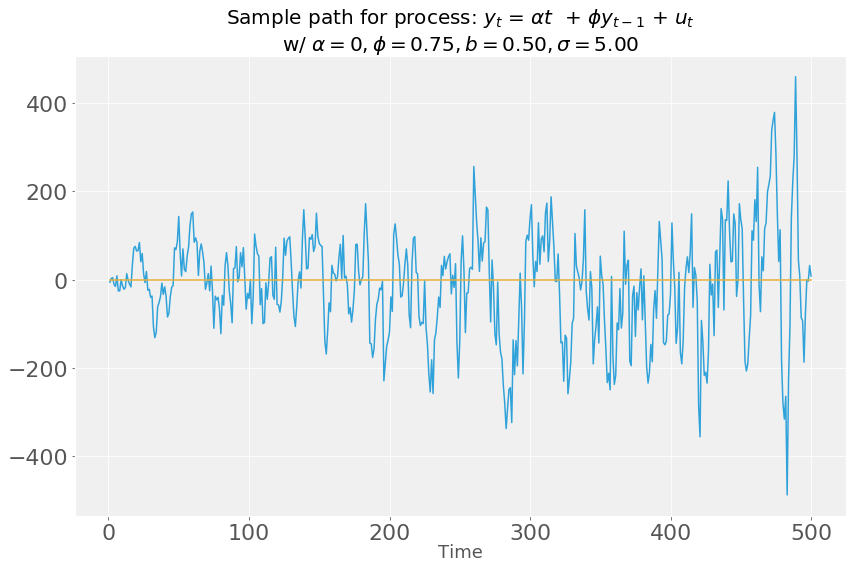

In [4]:
### Plot one simulated sample paths
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(TT, Y)
axes.plot(TT, alpha*TT)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\\alpha t$  + $\\phi y_{t-1} $ + $u_t$ \n' +
               'w/ $\\alpha={:.0f}, \\phi={:.2f}, b={:.2f}, \\sigma={:.2f}$'\
                          .format(alpha, phi, trend_b, sigma_eps), fontsize=20)
fig.tight_layout()

In the figure above, we display *both* a simulated path for the $y$ process with heteroskedastic disturbances, as well as the actual linear time trend, $\alpha t$ (here set to zero since $\alpha=0$). 

We can see that as time $t$ <u>increases</u>, the volatility of the process also <u>increases</u>. 

Let's re-introduce the "wrapper" for the `statsmodels` OLS regression estimation routine from **Lab 2**. The add-on is that now we will also return a confidence interval for each of our parameter estimates (from each of our simulations). 

Recalling from Introductory Statistics, the asymptotic **size** of a test of the null hypothesis that a parameter coefficient is equal to zero can be written down as follows:

For the null hypothesis $\mathbf{H}_0: \beta = \beta_0 = 0$, where $\beta$ is a parameter of interest,  then the test-statistic $T(\beta_0)=T(0)$ converges in distribution to $Z\sim N(0, 1)$.
For critical value $c$ satisfying $\gamma = 2(1 - \Phi(c))$, where  $\Phi(c)$ is the standard Gaussian CDF evaluated at $c$, then 

$$
\mathbf{P}(\mid T(0) \mid > c \mid \mathbf{H}_0) \rightarrow \gamma
$$

and the test "Reject $\mathbf{H}_0$ if $\mid T(0) \mid > c$" has asymptotic size $\gamma$.

In other words, the **size of a test** is the probability of falsely rejecting the null hypothesis. That is, it is the probability of making a **Type I error**. 

For each of our simulations, we will obtain (1 - $\gamma$)% asymptotic confidence intervals i.e. at significance level $\gamma$ (with $\gamma=0.05$), which give us the set of parameter values not rejected by the test that $\phi=0$. This in turn gives us the value of a random variable equal to 1 if we fail to reject the null, 0 otherwise. 

By averaging these values, we can then get the probability of accepting (i.e failing to reject) the null under the assumption of a true null. 1 minus this probability is equal to the probability of rejecting the null under the assumption of a true null i.e. the **size** of our test or **Type I** error probability. This probability should be close to 5%.

In [5]:
### "wrapped" OLS statsmodel routine
def _sm_calc_ols(y, x, addcon=True, cov_type=None, sig_level=.05, summary=0):
    """Wrapper for statsmodels OLS regression
    """
    if addcon:
        X = sm.add_constant(x)
    else:
        X = x 
    if cov_type==None:
        ols_results = sm.OLS(y,X).fit(cov_type='nonrobust')
    else:
        ols_results = sm.OLS(y,X).fit(cov_type=cov_type)
     
    ### print out the OLS estimation results
    if summary==1:
        print(ols_results.summary())  
    
    ols_beta_hat = ols_results.params # beta_hat
    ols_resids   = ols_results.resid  # resids
    ols_ci       = ols_results.conf_int(alpha=sig_level)[-2:] # 95% confidence intervals
    
    return ols_beta_hat, ols_resids, ols_ci

Also, let's define a similar "wrapper" for the `statsmodels` GLS regression routine. This routine requires that we provide `statsmodels` with the variance-covariance matrix of the errors $u_t$, here being $\widetilde{\mathbf{D}}$, not just $\mathbf{D}$. Of course if we set $\sigma=1$, then $\widetilde{\mathbf{D}}=\mathbf{D}$.

We will also report the (1 - $\gamma$)% asymptotic confidence intervals for $\phi$, which will help us get the **size** of our statistical significant tests.

In [6]:
### "wrapped" GLS statsmodel routine
def _sm_calc_gls(y, x, Dtilde, addcon=True, cov_type=None, sig_level=.05, summary=0):
    """Wrapper for statsmodels GLS regression
       Note: we need to specify the "D" matrix in GLS.
    """  
    if addcon:
        X = sm.add_constant(x)
    else:
        X = x
    
    ### SEs...    
    if cov_type==None:
        gls_results = sm.regression.linear_model.GLS(y,X, sigma=Dtilde).fit(cov_type='nonrobust')
    else:
        gls_results = sm.regression.linear_model.GLS(y,X, sigma=Dtilde).fit(cov_type=cov_type)
      
    ### print out the OLS estimation results
    if summary==1:
        print(gls_results.summary())  
    
    gls_beta_hat = gls_results.params # beta_hat
    gls_resids   = gls_results.resid  # resids
    gls_ci       = gls_results.conf_int(alpha=sig_level)[-2:] # 95% confidence intervals
    
    return gls_beta_hat, gls_resids, gls_ci

In addition, I will consider a general linear model with weighting matrix $W$ (see **Lecture Notes 3, slide 7**). In other words, $W$ will have form:

$$
\frac{1}{\sigma}\left[
  \begin{array}{cccc}
  1 & 0   & 0   &... & 0 \\
  0 & \frac{1}{2^{b}} & 0   &... & 0 \\
  0 & 0   & \frac{1}{3^{b}} &... & 0 \\ 
  . & .   & .   &... & . \\
  . & .   & .   &... & . \\
  0 & 0   & .   &... & \frac{1}{T^{b}} \\
  \end{array}
\right]
$$


I will recycle the function `calc_ols` from **Lab 3**, as well as the function `nth_moment`. As in the "wrapper" functions for OLS and GLS `statsmodels`, we also report (1 - $\gamma$)% asymptotic confidence intervals for $\phi$.

In [7]:
def nth_moment(y, counts, center, n):
    """ Calculates nth moment around 'center"""
    return np.sum((y - center)**n) / np.sum(counts)

In [8]:
def calc_general_ls(y, x, W, addcon=True, cov_type=None, sig_level=.05):
        
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs, 1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x   
    k = X.shape[1]   
    
    XtWtWX = np.dot(np.dot(X.T, W.T), np.dot(W, X))  # Construct sample average of E[X'W'WX]
    XtWtWy = np.dot(np.dot(X.T, W.T), np.dot(W, y))  # Construct sample average of E[X'W'Wy]
    XtWtWX_inv = np.linalg.inv(XtWtWX)
    WX = np.dot(W, X)        
              
    ### General weighted estimator: algebraic solution for "beta_hat" = (E[X'W'WX]^-1)*(E[X'W'Wy])
    beta_hat =  np.linalg.solve(XtWtWX, XtWtWy) 
    
    ### R-squared (can use np.dot or @ for "dot product")
    y_hat  = np.dot(X, beta_hat)   
    res = y - y_hat
    
    ytilde = np.dot(W, y)
    ymean  = (1/Nobs)*np.dot(np.dot(np.dot(np.dot(y.T, W.T), np.ones((Nobs,Nobs))), W), y).squeeze()
    restilde = np.dot(W, res)
    sse = np.dot(restilde.T, restilde).squeeze()
    sst = np.dot(ytilde.T, ytilde).squeeze() -  ymean 
    r_squared = 1 - sse/sst 
     
    ### Adjusted R-squared
    r_squared_adj = r_squared - (1 - r_squared)*((k - 1)/(Nobs - k))
  
    ### Variance-Covariance matrix: non-robust homoskedastic SEs
    sigma2_hat = sse / (Nobs - k)
    sigma2_mle = np.dot(res.T, res).squeeze() / (Nobs - 1)
    cov_matrix = np.dot(XtWtWX_inv, sigma2_hat)
    se = cov_matrix.diagonal()**0.5
    tstat = beta_hat.T / se
    ci_95 = np.vstack((beta_hat.T - 1.96*se, beta_hat.T + 1.96*se)) #--> 95% non-robust CI

    ### Variance-Covariance matrix: White (robust) heteroskedastic SEs:    
    Sigma2_hat = np.diag((restilde**2).T[0])
    cov_matrix_r = np.dot(np.dot(np.dot(np.dot(XtWtWX_inv, WX.T), Sigma2_hat), WX), XtWtWX_inv)
    cov_matrix_r_unbiased = cov_matrix_r
    se_r = cov_matrix_r_unbiased.diagonal()**0.5
    tstat_r = beta_hat.T / se_r
    ci_95_r = np.vstack((beta_hat.T - 1.96*se_r, beta_hat.T + 1.96*se_r)) #--> 95% robust CI
   
    
    ### log-likelihood (assumption of normality) [a little off -- please fix]:
    loglikelihood = - (Nobs/2)*np.log(2*np.math.pi) - \
                      (Nobs/2)*np.log(sigma2_mle) - \
                      (1/(2*sigma2_mle))*sum(res**2)
   
    ### Information criteria [a little off -- please fix]:
    hannan_quinn = ((-2*loglikelihood)/Nobs) + ((2*(k - 1)*math.log(math.log(Nobs)))/Nobs)
    aic = -2*loglikelihood + 2*k
    bic = -2*loglikelihood + (math.log(Nobs))*k
    
    ### Higher-order moments of the residuals:
    m1 = nth_moment(restilde, restilde.shape[0], center=0,  n=1)
    m2 = nth_moment(restilde, restilde.shape[0], center=m1, n=2)
    m3 = nth_moment(restilde, restilde.shape[0], center=m1, n=3)
    m4 = nth_moment(restilde, restilde.shape[0], center=m1, n=4)   
    skew = m3 / (m2**(3/2))
    kurtosis = m4 / (m2**2)
    
        
    ls_results = {'beta_hat': beta_hat.squeeze(),
                  'standard-errors': se.squeeze(), 
                  't-stat': tstat.squeeze(),
                  'ci_95': ci_95,
                  'standard-errors (robust)': se_r.squeeze(), 
                  't-stat (robust)': tstat_r.squeeze(),
                  'ci_95_r': ci_95_r}   
    
    ls_stats = {"No. Observations": Nobs,
             "Df Residuals": Nobs - k,
             "Skewness of residuals:": skew,
             "Kurtosis of residuals:": kurtosis,
             "$R^2$":  r_squared,
             "adjusted-$R^2$": r_squared_adj,
             "Log-likelihood": loglikelihood.squeeze(),
             "Hannan-Quinn": hannan_quinn.squeeze(),
             "AIC": aic.squeeze(), 
             "BIC": bic.squeeze()}
    
    return ls_results, ls_stats

To verify our function `calc_general_ls` works properly, let's consider the special case with the weighting matrix $W$ from **GLS**. Let's apply our function on a simulated path:

Even though we set $\alpha=0$, we will still include the time trend in our matrix of right hand side variables (as well as constant). We should see that the estimated coefficient $\widehat\alpha$ is not statistically difference from zero (i.e. we FAIL TO REJECT the null hypothesis that $\alpha=0$ at a significance level $\gamma$ of 5% or lower). 

In [9]:
### Test out our least squares estimator w/ W = 1/std(u_t)
nsample_T = 500
phi = .75
alpha = 0
sigma = 5
trend_b = 0.5

### Re-simulate a path...
np.random.seed(123)
Y, Ylag, TT = sim_ar1_linear_trend_het_shocks(ar1_coef=phi, nsample=nsample_T, burnin=0, 
                                              trend_coef=alpha, sigma=sigma_eps, t_b=trend_b, paths=1)

### Prepare data...
y = Y[:-1,:]
tt = TT[:-1]
x = np.c_[tt, Ylag]

### Weighting matrix is 1/std(u_t)
diag_sigma = sigma*(tt**trend_b)
W = np.linalg.inv(np.diag(diag_sigma.T[0]))

ar1_ls_results, ar1_ls_stats = calc_general_ls(y, x, W, addcon=True, cov_type=None, sig_level=.05)


In [10]:
### Compute AR(1) with time trend via OLS: parameter estimates
ar1_est_df = pd.DataFrame(index=['$\mu$', '$\\alpha$', '$\phi$'])
ar1_est_df["Estimates"] = ar1_ls_results['beta_hat']
ar1_est_df["(non-robust) SEs"] = ar1_ls_results['standard-errors']
ar1_est_df["(non-robust) $t$-stat"] = ar1_ls_results['t-stat']
ar1_est_df["(robust) SEs"] = ar1_ls_results['standard-errors (robust)']
ar1_est_df["(robust) $t$-stat"] = ar1_ls_results['t-stat (robust)']
ar1_est_df

,Estimates,(non-robust) SEs,(non-robust) $t$-stat,(robust) SEs,(robust) $t$-stat
$\mu$,-0.594,2.303,-0.258,2.799,-0.212
$\alpha$,-0.012,0.017,-0.723,0.018,-0.697
$\phi$,0.747,0.029,25.341,0.029,25.890


In [11]:
### Compute AR(1) with time trend via OLS: stats
ar1_stat_df = pd.DataFrame.from_dict(ar1_ls_stats, orient='index', 
                                     columns=['OLS statistics/diag'])
ar1_stat_df.loc['No. Observations'] = ar1_stat_df.loc['No. Observations'].apply('{:.0f}'.format)
ar1_stat_df.loc['Df Residuals'] = ar1_stat_df.loc['Df Residuals'].apply('{:.0f}'.format)
ar1_stat_df.loc['Log-likelihood'] = ar1_stat_df.loc['Log-likelihood'].apply('{:.3f}'.format)
ar1_stat_df.loc['Hannan-Quinn'] = ar1_stat_df.loc['Hannan-Quinn'].apply('{:.3f}'.format)
ar1_stat_df.loc['$R^2$'] = ar1_stat_df.loc['$R^2$'].apply('{:.3f}'.format)
ar1_stat_df.loc['adjusted-$R^2$'] = ar1_stat_df.loc['adjusted-$R^2$'].apply('{:.3f}'.format)
ar1_stat_df.loc['AIC'] = ar1_stat_df.loc['AIC'].apply('{:.3f}'.format)
ar1_stat_df.loc['BIC'] = ar1_stat_df.loc['BIC'].apply('{:.3f}'.format)
ar1_stat_df

,OLS statistics/diag
No. Observations,499
Df Residuals,496
Skewness of residuals:,-0.028
Kurtosis of residuals:,2.907
$R^2$,0.566
adjusted-$R^2$,0.564
Log-likelihood,-2880.273
Hannan-Quinn,11.559
AIC,5766.545
BIC,5779.183


#### Comparison to GLS `statsmodels` (non-robust):

In [12]:
### Compute AR(1) w/ time trend via 'statsmodels' GLS: non-robust SEs.
diag_sigma2 = (sigma**2)*(tt**(2*trend_b))
Dtilde = np.diag(diag_sigma2.T[0])

ar1_gls_beta,_, ar1_gls_ci = _sm_calc_gls(y, x, Dtilde=Dtilde, addcon=True, 
                                          cov_type=None, sig_level=.05, summary=1)


                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            GLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     323.7
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.10e-90
Time:                        01:30:00   Log-Likelihood:                -2816.2
No. Observations:                 499   AIC:                             5638.
Df Residuals:                     496   BIC:                             5651.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5936      2.303     -0.258      0.7

#### Comparison to GLS `statsmodels` (robust):

In [13]:
## Compute AR(1) via 'statsmodels' GLS: robust SEs.
ar1_gls_beta,_, ar1_gls_ci = _sm_calc_gls(y, x, Dtilde, addcon=True, 
                                          cov_type='HC0', sig_level=.05, summary=1)


                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            GLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     340.6
Date:                Sat, 18 May 2019   Prob (F-statistic):           8.23e-94
Time:                        01:30:01   Log-Likelihood:                -2816.2
No. Observations:                 499   AIC:                             5638.
Df Residuals:                     496   BIC:                             5651.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5936      2.799     -0.212      0.8

Our function `calc_general_ls` reproduces the same output as that of `_sm_calc_gls` when we use a weighting matrix $W$ consistent with **GLS** (which in our case will also be **WLS** since we have heteroskedasticity in the errors $u_t$, but no serial correlation).

Next, I will define a function that calculates the rejection probabilities for the null hypothesis that our regression parameter estimates are statistically significant from zero at a significance level of $\gamma$. In other words, we return the **size** of our tests (as discussed earlier).

These rejection probabilities will depend on how we treat our standard errors. 

In [14]:
def calc_rej_probs(ci_bounds, true_params):
    """
    PARAM: "ci_bounds": 'DataFrame' object with columns indexing the CI for each parameter, 
                        rows indexing each simulation.
                        
    PARAM: "true_params": list with "true" parameter values. 
    RETURN: "rej_prob": 'NumPy' array with rejection probabilities of the null under a true null
                        (of the null of zero statistical sigificance) at the 5% significance level 
                         for each parameter in the model                     
    """   
    ci_bool = np.empty(ci_bounds.shape)

    ### Iterate through parameters of interest
    for k in range(0, ci_bool.shape[1]):
        ci_bounds_k = np.vstack(ci_bounds.iloc[:, k])
        ci_bool[:, k] = (ci_bounds_k[:, 0] < true_params[k]) & (true_params[k] < ci_bounds_k[:, 1])

    ### Rejection probability = 1 - Acceptance probability    
    rej_prob = 1 - ci_bool.mean(axis=0)

    return rej_prob

We now want to simulate 10,000 paths for the process, each of length $T=500$.

In [15]:
### Repeated simulations: store estimates and accept/reject values
Nsims = 10000

### 1. OLS
ols_coefs       = np.empty((Nsims, 3))
ols_ci_bounds   = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])
ols_ci_bounds_r = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])

### 2. GLS
gls_coefs       = np.empty((Nsims, 3))
gls_ci_bounds   = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])
gls_ci_bounds_r = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])

### 3. LS with weight matrix W = 1/std(u_t)
ls_coefs       = np.empty((Nsims, 3))
ls_ci_bounds   = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])
ls_ci_bounds_r = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])

nsample_T = 500
phi = .75
alpha = 0
sigma = 5
trend_b = 0.5

np.random.seed(1)

### Simulate "Nsims" paths:
### Note: each "column" in Y is a simulated path of length "nsample_T = 500"
Y, Ylag, TT = sim_ar1_linear_trend_het_shocks(ar1_coef=phi, nsample=nsample_T, burnin=0, 
                                              trend_coef=alpha, sigma=sigma, t_b=trend_b, paths=Nsims)
### need to make sure "Y" and "TT" account for the dependent lag
y = Y[:-1,:]
tt = TT[:-1]

### Weighting matrix is 1/std(u_t)
diag_sigma = sigma*(tt**trend_b)
W = np.linalg.inv(np.diag(diag_sigma.T[0]))

diag_sigma2 = (sigma**2)*(tt**(2*trend_b))
Dtilde = np.diag(diag_sigma2.T[0])

for ss in range(Nsims): 
    """
    1. OLS: set up the 'statsmodels' object
    """
    ols_beta_hat  ,_,ols_ci   = _sm_calc_ols(y[:,ss], np.c_[tt, Ylag[:,ss]], addcon=True)    
    ols_beta_hat_r,_,ols_ci_r = _sm_calc_ols(y[:,ss], np.c_[tt, Ylag[:,ss]], addcon=True, cov_type='HC0')
        
    ### Store regression estimates in [Nsims x K] numpy array, 
    ### with "K" = # of parameters excluding constant
    ols_coefs[ss, :] = ols_beta_hat
      
    ### Store confidence intervals for each parameter in 'DataFrame' object
    ### Note: "non-robust" and White (robust)
    ols_ci_bounds.iloc[ss]   = [ols_ci[0],   ols_ci[1]]
    ols_ci_bounds_r.iloc[ss] = [ols_ci_r[0], ols_ci_r[1]]
    
    
    """
    2. GLS: set up the 'statsmodels' object
    """
    gls_beta_hat  ,_,gls_ci   = _sm_calc_gls(y[:,ss], np.c_[tt, Ylag[:,ss]], 
                                               Dtilde=Dtilde, addcon=True)    
    gls_beta_hat_r,_,gls_ci_r = _sm_calc_gls(y[:,ss], np.c_[tt, Ylag[:,ss]], 
                                               Dtilde=Dtilde, addcon=True, cov_type='HC0')
    
    ### Store regression estimates in [Nsims x K] numpy array, 
    ### with "K" = # of parameters excluding constant
    gls_coefs[ss, :] = gls_beta_hat
  
    ### Store confidence intervals for each parameter in 'DataFrame' object
    gls_ci_bounds.iloc[ss]   = [gls_ci[0],   gls_ci[1]]
    gls_ci_bounds_r.iloc[ss] = [gls_ci_r[0], gls_ci_r[1]]

    
    """
    3.  Least squares with weight matrix W=1/std(u_t):
    """
    ar1_ls_results,_ = calc_general_ls(np.expand_dims(y[:,ss],axis=1), np.c_[tt, Ylag[:,ss]], 
                                       W=W, addcon=True, sig_level=.05) 

    ls_ci   = ar1_ls_results['ci_95'][-2:]
    ls_ci_r = ar1_ls_results['ci_95_r'][-2:]
    
    ### Store regression estimates in [Nsims x K] numpy array, 
    ### with "K" = # of parameters excluding constant
    ls_coefs[ss, :] = ar1_ls_results['beta_hat']
    
    ### Store confidence intervals for each parameter in 'DataFrame' object
    ls_ci_bounds.iloc[ss]   = [ls_ci[0],   ls_ci[1]]
    ls_ci_bounds_r.iloc[ss] = [ls_ci_r[0], ls_ci_r[1]]    
    

### 1. OLS: Rejection probabilities
ols_reject_prob   = calc_rej_probs(ci_bounds=ols_ci_bounds,   true_params=[alpha, phi])
ols_reject_prob_r = calc_rej_probs(ci_bounds=ols_ci_bounds_r, true_params=[alpha, phi])

### 2. GLS: Rejection probabilities
gls_reject_prob   = calc_rej_probs(ci_bounds=gls_ci_bounds,   true_params=[alpha, phi])
gls_reject_prob_r = calc_rej_probs(ci_bounds=gls_ci_bounds_r, true_params=[alpha, phi])

### 3. LS w/ weight matrix W: Rejection probabilities
ls_reject_prob   = calc_rej_probs(ci_bounds=ls_ci_bounds,   true_params=[alpha, phi])
ls_reject_prob_r = calc_rej_probs(ci_bounds=ls_ci_bounds_r, true_params=[alpha, phi])

Rejection probabilities of the parameter estimate $\widehat\phi$ for the **OLS** model with both **homoskedastic (non-robust) errors** and **heteroskedastic, White (robust) errors**.

In [16]:
### Rejection probabilities for the OLS model with both non-robust and robust SEs:
print('OLS rejection probabilities for "phi":')
print('\tOLS (non-robust SEs):  ', round(ols_reject_prob[-1], 3))
print('\tOLS (robust SEs):  ', round(ols_reject_prob_r[-1], 3))

OLS rejection probabilities for "phi":
	OLS (non-robust SEs):   0.099
	OLS (robust SEs):   0.064


Rejection probabilities of the parameter estimate $\widehat\phi$ for the **GLS** model with both **homoskedastic (non-robust) errors** and **heteroskedastic, White (robust) errors**.

In [17]:
### Rejection probabilities for the GLS model with both non-robust and robust SEs:
print('GLS rejection probabilities for "phi":')
print('\tGLS (non-robust SEs):  ', round(gls_reject_prob[-1], 3))
print('\tGLS (robust SEs):  ', round(gls_reject_prob_r[-1], 3))

GLS rejection probabilities for "phi":
	GLS (non-robust SEs):   0.077
	GLS (robust SEs):   0.081


Using our "brute force" least squares function which uses a weight matrix $W$ that is consistent with GLS estimation also produces the same rejection probabilities as above.

In [18]:
### Rejection probabilities for the OLS model with both non-robust and robust SEs:
print('LS w/ W=1/std(u_t) rejection probabilities for "phi":')
print('\tLS w/ W=1/std(u_t) (non-robust SEs):  ', round(gls_reject_prob[-1], 3))
print('\tLS w/ W=1/std(u_t) (robust SEs):  ', round(gls_reject_prob_r[-1], 3))

LS w/ W=1/std(u_t) rejection probabilities for "phi":
	LS w/ W=1/std(u_t) (non-robust SEs):   0.077
	LS w/ W=1/std(u_t) (robust SEs):   0.081


Let's analyze the empirical distribution of our set of point estimates for $\widehat \phi$.

First, I will look at summary statistics for both the **OLS** and **GLS** point estimates using the `monte_carlo_stats` function from **Lab 3**.

In [19]:
def monte_carlo_stats(np_coef, nsample, percentiles):
    coef_desc_T = pd.DataFrame(np_coef).describe(percentiles=percentiles)
    coef_desc_cols = "{}".format('T=' + str(nsample)) 
    coef_desc_T.rename(columns={0: coef_desc_cols}, inplace=True)
    coef_desc_T.loc['count'] = coef_desc_T.loc['count'].apply('{:.0f}'.format)
    return coef_desc_T

In [20]:
### OLS: Print summary statistics (w/ detailed percentiles)
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats = monte_carlo_stats(np_coef=ols_coefs[:,-1], nsample=nsample_T, percentiles=percentiles)
mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
T=500,10000,0.736,0.035,0.592,0.647,0.676,0.690,0.713,0.737,0.761,0.780,0.791,0.809,0.844


In [21]:
### GLS: Print summary statistics (w/ detailed percentiles)
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats = monte_carlo_stats(np_coef=gls_coefs[:,-1], nsample=nsample_T, percentiles=percentiles)
mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
T=500,10000,0.732,0.030,0.598,0.657,0.680,0.693,0.712,0.733,0.754,0.771,0.780,0.798,0.832


Once again, our "brute force" least squares routine will yield the same summary statistics as above:

In [22]:
### LS w/ weight matrix = W/std(u_t): Print summary statistics (w/ detailed percentiles)
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats = monte_carlo_stats(np_coef=ls_coefs[:,-1], nsample=nsample_T, percentiles=percentiles)
mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
T=500,10000,0.732,0.030,0.598,0.657,0.680,0.693,0.712,0.733,0.754,0.771,0.780,0.798,0.832


Let's now plot histograms of our **OLS** and **GLS** estimates:

In [23]:
nsample_T = 500
phi = .75
alpha = 0.5
sigma = 5
trend_b = 0.5

def plot_estimates(ols_phi_hat, gls_phi_hat, params): 
    
    alpha, phi, trend_b, sigma = params[0], params[1], params[2], params[3]   
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10))  
    
    """
    1. OLS: set up the 'statsmodels' object
    """
    ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_phi_hat),np.std(ols_phi_hat)) 
    ols_xlabel = '$\widehat\\phi_{ols}$'
    
    axes[0].hist(ols_phi_hat, bins=100, density=True, edgecolor = "black", label=ols_phi_label) 
    axes[0].set_xlabel(ols_xlabel, fontsize=24)
    axes[0].set_title('OLS : $y_t = \\alpha t + \\phi y_{t-1} + u_t$ \n ' +
                       'w/ $\\alpha={:.0f}, \\phi={:.2f}, b={:.2f}, \\sigma={:.2f}$'\
                        .format(alpha, phi, trend_b, sigma), fontsize=20) 
    
    ymin, ymax = axes[0].get_ylim()
    asy_mean = phi  
    axes[0].plot((asy_mean, asy_mean), (ymin, ymax), 'r--')
    axes[0].legend(fontsize=20)   
      
    """
    2. GLS: set up the 'statsmodels' object
    """
    gls_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(gls_phi_hat),np.std(gls_phi_hat)) 
    gls_xlabel = '$\widehat\\phi_{gls}$'
    
    axes[1].hist(gls_phi_hat, bins=100, density=True, edgecolor = "black", label=gls_phi_label) 
    axes[1].set_xlabel(gls_xlabel, fontsize=24)
    axes[1].set_title('GLS : $y_t = \\alpha t + \\phi y_{t-1} + u_t$ \n ' +
                       'w/ $\\alpha={:.0f}, \\phi={:.2f}, b={:.2f}, \\sigma={:.2f}$'\
                        .format(alpha, phi, trend_b, sigma), fontsize=20) 
    
    ymin, ymax = axes[1].get_ylim()
    asy_mean = phi  
    axes[1].plot((asy_mean, asy_mean), (ymin, ymax), 'r--')
    axes[1].legend(fontsize=22)        
        
        
    fig.tight_layout()   

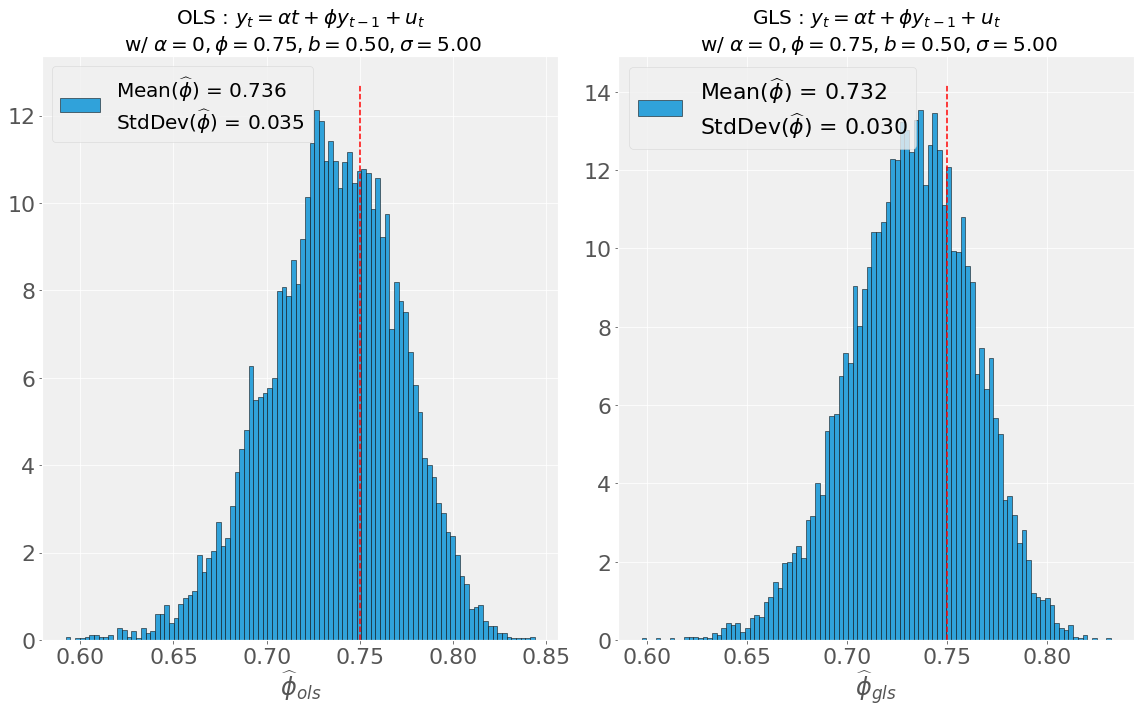

In [24]:
### Plot the histogram of "phi" OLS and GLS estimates
ols_phi = ols_coefs[:,-1]
gls_phi = gls_coefs[:,-1]

plot_estimates(ols_phi_hat=ols_phi, gls_phi_hat=gls_phi, params=[alpha, phi, trend_b, sigma])

### Discussion: 
We can see that given we **KNOW** $\mathbf{D}$, using **GLS** will provide us with more efficient estimates. This is seen in the histogram above, as well as in the econometric analysis from before. 

Given the structure of $\mathbf{D}$, what is the asymptotic distribution of both the **OLS** estimate $\widehat{\phi}_{ols}$ and **GLS** estimate  $\widehat{\phi}_{gls}$?

### Misspecification and GLS:

Recall that the **GLS** estimator can be computed easily if we know the structure of the variance-covariance matrix $\mathbf{D}$ in:

$$
E\left[ u u' | \mathbf{X} \right] = \sigma^2 \mathbf{D}
$$

If we don't know $\mathbf{D}$, we have to estimate it. If we have a diffuse prior on what $\mathbf{D}$ should be, we run the risk of grossly misspecifying $\mathbf{D}$! 

With a misspecified $\mathbf{D}$, an *efficient* **GLS** estimate in comparison to the **OLS** estimate may not be very useful in our work! We can also estimate it (this is **Feasible GLS**).

Let's revisit our model from before with $\alpha=0$, $\phi=0.75$, $b=0.5$, and $\sigma=5$. 

Now, let's forget that we know the "true" exponent power $b$, which gives us a <u>linear trend</u> in the variance of the error term: 

$$
Var_t\left[u_t\right] = E_t\left[u_t^2\right] = (\sigma t^{0.5})^2 = \sigma^2 t
$$

and let's suppose we "misspecify" the structure of the errors and estimate via **GLS** a model with $b=1$:

$$
Var_t\left[u_t\right] = E_t\left[u_t^2\right] = (\sigma t)^2 = \sigma^2 t^2
$$

This model assumes a <u>linear trend</u> in the *volatility* of the error term: 

In [25]:
### 1. OLS
ols_coefs       = np.empty((Nsims, 3))
ols_ci_bounds   = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])
ols_ci_bounds_r = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])

### 2. misspecified GLS
mgls_coefs       = np.empty((Nsims, 3))
mgls_ci_bounds   = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])
mgls_ci_bounds_r = pd.DataFrame(index = list(range(0,Nsims)), columns=['alpha', 'phi'])

### Misspecified trend in the errors:
miss_trend_b = 1

miss_diag_sigma2 = (sigma**2)*(tt**(2*miss_trend_b))
miss_Dtilde = np.diag(miss_diag_sigma2.T[0])

for ss in range(Nsims): 
    """
    1. OLS: set up the 'statsmodels' object
    """
    ols_beta_hat  ,_,ols_ci   = _sm_calc_ols(y[:,ss], np.c_[tt, Ylag[:,ss]], addcon=True)    
    ols_beta_hat_r,_,ols_ci_r = _sm_calc_ols(y[:,ss], np.c_[tt, Ylag[:,ss]], addcon=True, cov_type='HC0')
        
    ### Store regression estimates in [Nsims x K] numpy array, 
    ### with "K" = # of parameters excluding constant
    ols_coefs[ss, :] = ols_beta_hat
      
    ### Store confidence intervals for each parameter in 'DataFrame' object
    ### Note: "non-robust" and White (robust)
    ols_ci_bounds.iloc[ss]   = [ols_ci[0],   ols_ci[1]]
    ols_ci_bounds_r.iloc[ss] = [ols_ci_r[0], ols_ci_r[1]]
    
    
    """
    2. GLS: set up the 'statsmodels' object
    """
    mgls_beta_hat  ,_,mgls_ci   = _sm_calc_gls(y[:,ss], np.c_[tt, Ylag[:,ss]], 
                                               Dtilde=miss_Dtilde, addcon=True)    
    mgls_beta_hat_r,_,mgls_ci_r = _sm_calc_gls(y[:,ss], np.c_[tt, Ylag[:,ss]], 
                                               Dtilde=miss_Dtilde, addcon=True, cov_type='HC0')
    
    ### Store regression estimates in [Nsims x K] numpy array, 
    ### with "K" = # of parameters excluding constant
    mgls_coefs[ss, :] = mgls_beta_hat
  
    ### Store confidence intervals for each parameter in 'DataFrame' object
    mgls_ci_bounds.iloc[ss]   = [mgls_ci[0],   mgls_ci[1]]
    mgls_ci_bounds_r.iloc[ss] = [mgls_ci_r[0], mgls_ci_r[1]]


### 1. OLS: Rejection probabilities
ols_reject_prob   = calc_rej_probs(ci_bounds=ols_ci_bounds,   true_params=[alpha, phi])
ols_reject_prob_r = calc_rej_probs(ci_bounds=ols_ci_bounds_r, true_params=[alpha, phi])

### 2. GLS: Rejection probabilities
mgls_reject_prob   = calc_rej_probs(ci_bounds=mgls_ci_bounds,   true_params=[alpha, phi])
mgls_reject_prob_r = calc_rej_probs(ci_bounds=mgls_ci_bounds_r, true_params=[alpha, phi])

Below are the rejection probabilities for our original **OLS** and new **GLS** estimates:

In [26]:
### Rejection probabilities for the OLS model with both non-robust and robust SEs:
print('OLS rejection probabilities for "phi":')
print('\tOLS (non-robust SEs):  ', round(ols_reject_prob[-1], 3))
print('\tOLS (robust SEs):  ', round(ols_reject_prob_r[-1], 3))

OLS rejection probabilities for "phi":
	OLS (non-robust SEs):   0.099
	OLS (robust SEs):   0.064


In [27]:
### Rejection probabilities for the misspecified GLS model with both non-robust and robust SEs:
print('GLS rejection probabilities for "phi":')
print('\tGLS (non-robust SEs):  ', round(mgls_reject_prob[-1], 3))
print('\tGLS (robust SEs):  ', round(mgls_reject_prob_r[-1], 3))

GLS rejection probabilities for "phi":
	GLS (non-robust SEs):   0.779
	GLS (robust SEs):   0.302


The summary statistics from our Monte Carlo estimates are also below:

In [28]:
### OLS: Print summary statistics (w/ detailed percentiles)
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats = monte_carlo_stats(np_coef=ols_coefs[:,-1], nsample=nsample_T, percentiles=percentiles)
mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
T=500,10000,0.736,0.035,0.592,0.647,0.676,0.690,0.713,0.737,0.761,0.780,0.791,0.809,0.844


In [29]:
### GLS: Print summary statistics (w/ detailed percentiles)
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats = monte_carlo_stats(np_coef=mgls_coefs[:,-1], nsample=nsample_T, percentiles=percentiles)
mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
T=500,10000,0.622,0.094,0.123,0.349,0.455,0.501,0.568,0.632,0.686,0.730,0.757,0.815,0.943


Let's now plot the estimates of $\widehat\phi$ for OLS and our new GLS procedure:

In [30]:
nsample_T = 500
phi = .75
alpha = 0.5
sigma = 5

def plot_estimates(ols_phi_hat, gls_phi_hat, params): 
    
    alpha, phi, trend_b, sigma = params[0], params[1], params[2], params[3]   
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10))  
    
    """
    1. OLS: set up the 'statsmodels' object
    """
    ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_phi_hat),np.std(ols_phi_hat)) 
    ols_xlabel = '$\widehat\\phi_{ols}$'
    
    axes[0].hist(ols_phi_hat, bins=100, density=True, edgecolor = "black", label=ols_phi_label) 
    axes[0].set_xlabel(ols_xlabel, fontsize=24)
    axes[0].set_title('OLS : $y_t = \\alpha t + \\phi y_{t-1} + u_t$ \n ' +
                       'w/ $\\alpha={:.0f}, \\phi={:.2f}, b={:.2f}, \\sigma={:.2f}$'\
                        .format(alpha, phi, trend_b, sigma), fontsize=20) 
    
    ymin, ymax = axes[0].get_ylim()
    asy_mean = phi  
    axes[0].plot((asy_mean, asy_mean), (ymin, ymax), 'r--')
    axes[0].legend(fontsize=20)   
      
    """
    2. GLS: set up the 'statsmodels' object
    """
    gls_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(gls_phi_hat),np.std(gls_phi_hat)) 
    gls_xlabel = '$\widehat\\phi_{gls}$'
    
    axes[1].hist(gls_phi_hat, bins=100, density=True, edgecolor = "black", label=gls_phi_label) 
    axes[1].set_xlabel(gls_xlabel, fontsize=24)
    axes[1].set_title('Misspecified GLS : $y_t = \\alpha t + \\phi y_{t-1} + u_t$ \n ' +
                       'w/ $\\alpha={:.0f}, \\phi={:.2f}, b={:.2f}, \\sigma={:.2f}$'\
                        .format(alpha, phi, trend_b, sigma), fontsize=20) 
    
    ymin, ymax = axes[1].get_ylim()
    asy_mean = phi  
    axes[1].plot((asy_mean, asy_mean), (ymin, ymax), 'r--')
    axes[1].legend(fontsize=22)        
        
        
    fig.tight_layout()   

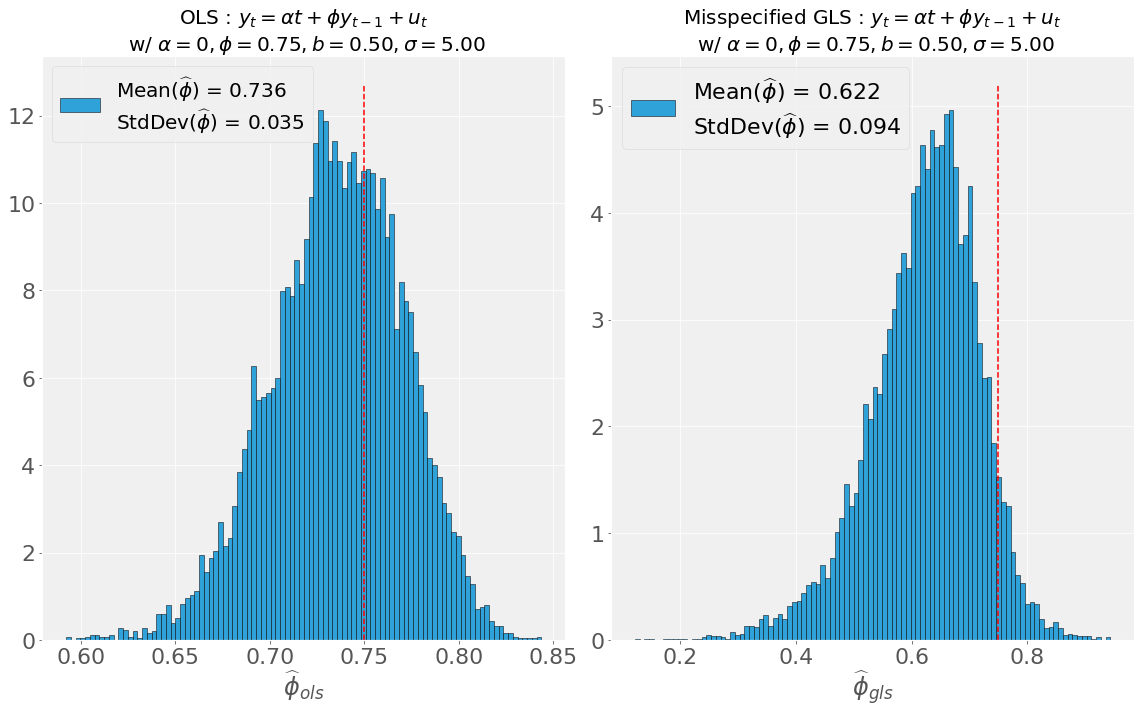

In [31]:
### Plot the histogram of "phi" OLS and misspecified GLS estimates
ols_phi  = ols_coefs[:,-1]
mgls_phi = mgls_coefs[:,-1]

plot_estimates(ols_phi_hat=ols_phi, gls_phi_hat=mgls_phi, params=[alpha, phi, trend_b, sigma])

### Discussion:

What do we see here? With knowledge of the "true" $b$, we saw that **GLS** is more EFFICIENT than **OLS**. However, without knowledge of "true" $b$, if we grossly misspecify structure of $\mathbf{D}$, in this case, grossly misspecify the trend in the second-order properties of the error terms, **GLS** is less EFFICIENT than **OLS**.

What else do you see here???

### Final Thought:

A nice GLS example can be found [here](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/gls.html).

## Example 2: GLS when errors follow an AR(1) process

Consider the linear regression model:
$$
y_t = \beta x_t + u_t \\
u_t = \phi u_{t-1}+\epsilon_t 
$$

where $x_t$ is exogeneous and $\epsilon_t \sim i.i.d. N(0, \sigma^2_{\epsilon})$. Let's also assume $x_t \sim i.i.d. N(0, \sigma^2_{x})$. Here, the variance of $u$ will be denoted $\sigma^2_{u}$

**Question**: Estimate the model by **GLS**.<br>

**Suggested steps:**
* Get the **OLS** residuals $\hat{u}_t$ and estimate $\hat{\phi}$.
* Construct an estimate of the variance-covariance matrix $\widetilde{\mathbf{D}} = \sigma^2_{u}\mathbf{D}$ matrix for **GLS** using the following fact: $Cov(u_t, u_{t-j}) = E[u_t u_{t-j}] = \frac{\sigma^2_{\epsilon}\phi^j}{1 - \phi^2}$
* Use the estimate of $\widetilde{\mathbf{D}}$ to then estimate $\hat{\beta}_{GLS}$


**Hints**:
* For constructing $\widetilde{\mathbf{D}}$, take a look at `scipy.linalg.toeplitz`

Let's assume $\beta=2$, $\phi=0.9$, and $T=500$.

In [32]:
### Simulate the linear model with AR(1) errors and estimate by OLS
beta = 2
phi = .9

### Use `statsmodels` function "sm.tsa.ArmaProcess" 
ar_model = sm.tsa.ArmaProcess(ar=[1, -phi], ma=[1])

nsample = 500
np.random.seed(1234)
print('Sample: %d' % nsample)

### Simulate model: draw MA(1) shocks
U = ar_model.generate_sample(nsample)

### Draw exogeneous "x"
x = np.random.normal(size=nsample)

### Create the process "y" 
Y = beta*x + U

### Estimatethe the model via OLS to get residuals
X = sm.add_constant(x)
ols_model = sm.OLS(Y, X).fit()
ols_resid = ols_model.resid # OLS residuals "u_hat" used to estimate Dtilde. 

print(ols_model.summary())

Sample: 500
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     401.0
Date:                Sat, 18 May 2019   Prob (F-statistic):           7.06e-66
Time:                        01:44:04   Log-Likelihood:                -1072.7
No. Observations:                 500   AIC:                             2149.
Df Residuals:                     498   BIC:                             2158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1970      0.093      2.

Let's look at the *ACF* and *PACF* of the residuals from the above regression:

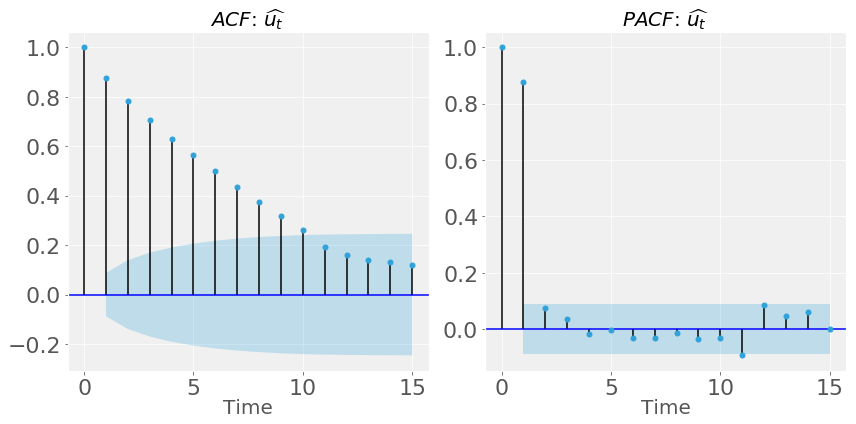

In [33]:
### Import 'statsmodels' routines for  ACF/PACF plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 15
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_acf(ols_resid, ax=axes[0], lags=nlags)
plot_pacf(ols_resid, ax=axes[1], lags=nlags)

axes[0].set_xlabel('Time', fontsize=20)
axes[0].set_title("${\it ACF}$: $\widehat{u_t}$", fontsize=20)

axes[1].set_xlabel('Time', fontsize=20)
axes[1].set_title("${\it PACF}$: $\widehat{u_t}$", fontsize=20)
fig.tight_layout()

Since the *ACF* of the OLS residuals $\widehat{u_t}$ decays exponentially to zero as the lag increases and the *PACF* cuts off after one lag, then this confirms that the estimated errors follow an AR($1$) process.

Of course, the exact $\phi$  is not known so it it might make more sense to use **Feasible GLS** (see **Lecture slides 3, page 11**).

We can now construct the $\widetilde{\mathbf{D}} = \sigma^2_{u}\mathbf{D}$ matrix for **GLS**, which uses the fact that $Cov(u_t, u_{t-j}) = E[u_t u_{t-j}] = \frac{\sigma^2_{\epsilon}\phi^j}{1 - \phi^2}$.

Recall that the autocorrelation function, *ACF*, of the AR($1$) error process ${u}$ at some lag $j>0$ is given by:

$$
 Corr(u_t, u_{t-j})=\frac{Cov(u_t, u_{t-j})}{\sqrt{(Var(u_t)(Var(u_{t-j})}} 
 = \frac{Cov(u_t, u_{t-j})}{Var(u_t)} = \frac{ \frac{ \sigma^2_{\epsilon} \phi^{j} }{1 - \phi^2}}{ \frac{ \sigma^2_{\epsilon}}{1 - \phi^2}} = \phi^{j}
$$


Hence, $\sigma^2_{u}\mathbf{D(\mathbf{X})}$  will have the form:

$$
\frac{\sigma^2_{\epsilon}}{1 - \phi^2} 
\left[
 \begin{array}{cccc}
  1 & \phi   & \phi^2   &... & \phi^{T-1} \\
  \phi & 1 & \phi  &... &\phi^{T-2} \\
  \phi^2 &  \phi   & 1 &... & \phi^{T-3} \\ 
  . & .   & .   &... & . \\
  . & .   & .   &... & . \\
  \phi^{T-1} & \phi^{T-2}   & .   &... & 1 \\
  \end{array}
\right]
$$

where $\sigma^2_{u} = \frac{\sigma^2_{\epsilon}}{1 - \phi^2}$. 

With **Feasible GLS**, since we don't "know" $\phi$, we need to estimate the matrix $\mathbf{D}$ as well as $\sigma^2_{u}=\frac{\sigma^2_{\epsilon}}{1 - \phi^2} $. 

Though we would think to use our estimate of $\phi$ to estimate $\sigma^2_{u}$ (since the denominator has the term $(1 - \phi^2))$, we also don't know $\sigma^2_{\epsilon}$. Instead, we can use the sample variance of our residuals from the OLS regression of $y_t = \beta x_t +u_t$ to estimate $\sigma^2_{u}$.

In [34]:
###
### Estimate an AR(1) for the residuals "u_hat" and construct the "Dtilde" matrix from GLS. 
###

### Estimate "phi" using "ols_resid" (AR(1) for residuals from "OLS" in previous cell)
resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
phi_hat = resid_fit.params[1]

print('Residual AR(1) parameter: %.03f' %  phi_hat)
print('t-stat: %.03f' %  resid_fit.tvalues[1])

### Create "Dtilde"
from scipy.linalg import toeplitz
order = toeplitz(range(len(ols_resid)))
D = phi_hat**order

### Sample variance of u_hat:
sigma2_u_hat = np.var(ols_resid)
print(sigma2_u_hat)

print("Sample variance of OLS residuals 'u_hat': ", round(sigma2_u_hat, 3))
Dtilde = sigma2_u_hat*D
      
print('\nRows 1-10 of D:')
print(D[0:10,0:10], '\n')
      
print('\nRows 1-10 of Dtilde:')
print(Dtilde[0:10,0:10], '\n')      

Residual AR(1) parameter: 0.887
t-stat: 41.454
4.2753242926541555
Sample variance of OLS residuals 'u_hat':  4.275

Rows 1-10 of D:
[[1.    0.887 0.788 0.699 0.62  0.55  0.489 0.434 0.385 0.341]
 [0.887 1.    0.887 0.788 0.699 0.62  0.55  0.489 0.434 0.385]
 [0.788 0.887 1.    0.887 0.788 0.699 0.62  0.55  0.489 0.434]
 [0.699 0.788 0.887 1.    0.887 0.788 0.699 0.62  0.55  0.489]
 [0.62  0.699 0.788 0.887 1.    0.887 0.788 0.699 0.62  0.55 ]
 [0.55  0.62  0.699 0.788 0.887 1.    0.887 0.788 0.699 0.62 ]
 [0.489 0.55  0.62  0.699 0.788 0.887 1.    0.887 0.788 0.699]
 [0.434 0.489 0.55  0.62  0.699 0.788 0.887 1.    0.887 0.788]
 [0.385 0.434 0.489 0.55  0.62  0.699 0.788 0.887 1.    0.887]
 [0.341 0.385 0.434 0.489 0.55  0.62  0.699 0.788 0.887 1.   ]] 


Rows 1-10 of Dtilde:
[[4.275 3.794 3.367 2.988 2.652 2.353 2.089 1.853 1.645 1.46 ]
 [3.794 4.275 3.794 3.367 2.988 2.652 2.353 2.089 1.853 1.645]
 [3.367 3.794 4.275 3.794 3.367 2.988 2.652 2.353 2.089 1.853]
 [2.988 3.367 3.794 4.27

The **OLS** estimate of $\phi$ is 0.887, almost identical to the true value of 0.9.

Equipped with our estimate of $\mathbf{D}$, we can now implement **Feasible GLS**:

In [35]:
### Estimate GLS with sigma = Dtilde
gls_model = sm.GLS(Y, X, sigma=Dtilde)
gls_results = gls_model.fit()
print(gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            GLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4087.
Date:                Sat, 18 May 2019   Prob (F-statistic):          3.31e-242
Time:                        01:44:05   Log-Likelihood:                -689.01
No. Observations:                 500   AIC:                             1382.
Df Residuals:                     498   BIC:                             1390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1127      0.376      0.300      0.7

### Discussion:
We get a **Feasible GLS** estimate for $\beta$ of 2.0300, which is almost identical to the true value. 

We could also use White (robust) heteroskedastic errors, which are unnecessary here.

In [36]:
gls_results_r = gls_model.fit(cov_type='HC0')
print(gls_results_r.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            GLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4205.
Date:                Sat, 18 May 2019   Prob (F-statistic):          5.75e-245
Time:                        01:44:05   Log-Likelihood:                -689.01
No. Observations:                 500   AIC:                             1382.
Df Residuals:                     498   BIC:                             1390.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1127      0.408      0.276      0.7

We can also use the **[Generalized Least Squares Autoregressive (GLSAR) model](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.GLSAR.html)** in `statsmodels` with one lag, to get to a similar result:

`statsmodels.regression.linear_model.GLSAR(endog, exog=None, rho=1, missing='none', **kwargs)`

The **GLSAR** model is a regression model with an AR($p$) covariance structure. The parameter `rho` in the `GLSAR` routine refers to the order of the autoregressive covariance structure of the shocks. Hence, to compare to the previous code we set `rho=1`.

In [37]:
### GLSAR implementation:
glsar_model = sm.GLSAR(endog=Y, exog=X, rho=1)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.446
Model:                          GLSAR   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     399.9
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.04e-65
Time:                        01:44:05   Log-Likelihood:                -1071.0
No. Observations:                 499   AIC:                             2146.
Df Residuals:                     497   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1964      0.093      2.115      0.0

In comparing the estimate of $\beta$ (and its standard error) for both the **GLS** and **GLSAR** model implementations, we do see some slight differences, which may be due to numerical errors in the algorithm (see cell below).

As a general practice, always check the source code of a function from a package/library you are using. In our case, the source code for `GLSAR` routine from `statsmodels` can be found [here](https://www.statsmodels.org/dev/_modules/statsmodels/regression/linear_model.html#GLSAR).

In [38]:
### Comparison of 'statsmodels' GLS and GLSAR:
print('GLS estimate of beta: %.03f' % gls_results.params[-1])
print('GLSAR estimate of beta: %.03f' % glsar_results.params[-1])

GLS estimate of beta: 2.030
GLSAR estimate of beta: 1.881


## Exercise 3: MA($q$) and ARMA($p$, $q$) models: OLS and IV

**Model 1**: Consider the regression model with MA($1$) errors:
$$
y_t = \beta x_t + u_t \\
u_t = \epsilon_t + \theta \epsilon_{t-1}
$$

where $x_t$ is exogeneous and $\epsilon_t \sim i.i.d. N(0, \sigma^2_{\epsilon})$. Assume $x_t \sim i.i.d. N(0, 1)$ and $\sigma^2_{\epsilon}=1$.

**Question 1**: Simulate *Model 1* using the code below for different $\beta$'s and estimate $\beta$ by **OLS**.  Describe your results.  


**Model 2**: Now consider the ARMA($1$,$1$) process
$$
y_t = \phi y_{t-1} + u_t \\
u_t = \epsilon_t + \theta \epsilon_{t-1}
$$

also with $\epsilon_t \sim i.i.d. N(0, \sigma^2_{\epsilon})$.

**Question 2**: Simulate *Model 2* using the code below for different $\beta$'s and estimate $\beta$ by OLS.  Describe your results. 

**Question 3**: How could you fix potential problems with **IV** regressions?

**Hints**:
* You can use `gmm.IV2SLS` (imported from `statsmodels.sandbox.regression`) as well as `sm.tsa.tsatools.lagmat` to create a numpy array of lags

### Question 1: Regression model with MA(1) errors

Let's assume $\beta=2$ and $\theta=0.9$. Let's also consider sample sizes $T=100,500,1000,5000,10000,20000$.

In [39]:
### Model 1 
beta = 2
theta = .9

ma_model = sm.tsa.ArmaProcess(ar=[1], ma=[1, theta])

nsample_T = [100, 500, 1000, 5000, 10000, 20000]
for idx in range(0,len(nsample_T)):
    np.random.seed(1234)
    print('Sample Size T=%d' % nsample_T[idx])
    
    ### Simulate model: draw "MA" shocks
    U = ma_model.generate_sample(nsample=nsample_T[idx]) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.generate_sample.html
    
    ### Exogeneous "x"
    x = np.random.normal(size=nsample_T[idx])
    Y = beta*x + U
    
    ### Estimate via OLS
    X = sm.add_constant(x)
    ols_model = sm.OLS(Y, X)
    print('OLS (beta): %.03f' %  ols_model.fit().params[-1], '\n')


Sample Size T=100
OLS (beta): 2.126 

Sample Size T=500
OLS (beta): 1.965 

Sample Size T=1000
OLS (beta): 1.984 

Sample Size T=5000
OLS (beta): 2.028 

Sample Size T=10000
OLS (beta): 1.998 

Sample Size T=20000
OLS (beta): 2.002 



What do we see above?

### Questions 2 and 3: ARMA($1$,$1$) model

Let's assume $\phi=0.5$ and $\theta=0.9$. Let's also consider sample sizes $T=100,500,1000,5000,10000,20000$.


In addition, let's write a simple "brute force" IV regression function:

In [40]:
def calc_iv(y, x, z, addcon=True):
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs, 1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x   
    k = X.shape[1]   
    
    ZtX = np.dot(Z.T, X)
    Zty = np.dot(Z.T, y)
    
    beta_iv_hat =  np.linalg.solve(ZtX, Zty) 
    
    return beta_iv_hat

In [41]:
### Model 2: ARMA(1,1)
phi = 0.5
theta = 0.9

arma_model = sm.tsa.ArmaProcess(ar=[1,-phi], ma=[1,theta])

nsample_T = [100, 500, 1000, 5000, 10000, 20000]

for idx in range(0,len(nsample_T)):
    np.random.seed(1234)
    print('Sample Size T=%d' % nsample_T[idx])
    Y = arma_model.generate_sample(nsample=nsample_T[idx])
    
    ### Obtain lags using the routine "sm.tsa.tsatools.lagmat"
    x = sm.tsa.tsatools.lagmat(Y, maxlag=2, original='in')[2:,:]
    y  = x[:,0]
    x1 = x[:,1]
    x2 = x[:,2]
    
    ### Estimate via OLS
    X = sm.add_constant(x1)
    ols_model = sm.OLS(y, X)
    print('statsmodels OLS (phi): %.03f' %  ols_model.fit().params[-1])

    ### Estimate via IV using lag 2 of "x" as an instrument in 'statsmodels':
    Z = sm.add_constant(x2)
    iv_model = gmm.IV2SLS(y, X, instrument=Z)
    print('statsmodels IV (phi): %.03f' %  iv_model.fit().params[-1])
    
    ### Estimate via IV using lag 2 of "x" as an instrument (brute-force):
    iv_params = calc_iv(y, X, Z, addcon=False)
    print('brute-force IV (phi): %.03f' %  iv_params[-1], '\n')
    

Sample Size T=100
statsmodels OLS (phi): 0.630
statsmodels IV (phi): 0.177
brute-force IV (phi): 0.177 

Sample Size T=500
statsmodels OLS (phi): 0.736
statsmodels IV (phi): 0.496
brute-force IV (phi): 0.496 

Sample Size T=1000
statsmodels OLS (phi): 0.724
statsmodels IV (phi): 0.465
brute-force IV (phi): 0.465 

Sample Size T=5000
statsmodels OLS (phi): 0.747
statsmodels IV (phi): 0.497
brute-force IV (phi): 0.497 

Sample Size T=10000
statsmodels OLS (phi): 0.752
statsmodels IV (phi): 0.507
brute-force IV (phi): 0.507 

Sample Size T=20000
statsmodels OLS (phi): 0.755
statsmodels IV (phi): 0.510
brute-force IV (phi): 0.510 



#### Solution to Question 3: 
We implement **IV** by using the $2^{nd}$ lag of $y_t$. Why can we use the $2^{nd}$ lag of $y_t$? Because our errors have an MA($1$) structure and we know that $y_{t-2}$ is correlated with $y_{t-1}$ but orthogonal to $\epsilon_t$ and $\epsilon_{t-1}$. Hence it is a valid instrument (see **Lecture 3 slides**).

However, if we started with an AR($1$) error structure:

$$
y_t = \phi y_{t-1} + u_t \\
u_t = \rho u_{t-1} + \epsilon_t
$$

also with $\epsilon_t \sim i.i.d. N(0, \sigma^2_{\epsilon})$, $\mid \rho\mid=1$.


then clearly $y_{t-2}$ would <u>not</u> be a valid instrument since it would be correlated with $u_{t-1}$ since 

$$
u_{t-1} = \rho u_{t-2} + \epsilon_{t-1} \\
y_{t-2} = \phi y_{t-3} + u_{t-2}
$$

We would have to think more carefully about finding the "right" instrument.

### Discussion:

For our MA($1$) error structure, we can see that our **IV** estimator for $\phi$, $\widehat{\phi}_{IV}$, provides a consistent estimate of the true $\phi$ as our sample size $T$ increases. 

## Exercise 4: Vector Autoregression (VAR)

Recall the VAR($p$) model generalizes the AR($p$) model:
$$
\mathbf{Y}_t = c + \sum_{j=1}^p \mathbf{A}_j \mathbf{Y}_{t-j} + \mathbf{e}_t
$$

where $\mathbf{Y}_t$ is a $K \times 1$ vector and each $\mathbf{A}_j$ is a $K \times K$ matrix of coefficients.

The dataset `ftse2011.dat` contains *daily* data for the **FTSE100**, **FTSE Mid Cap** and **FTSE Small Cap** stock indices for 2011.

**Question**: Using `sm.tsa.VAR`, determine the appropriate lag order using *AIC* and *BIC* and carry out **Granger causality** tests.

**Hints**:
* `sm.tsa.VAR().fit()`
* After fitting make use of diagnostic tools: `aic`, `bic`, `is_stable()`, `test_causality()`


As we have seen in earlier classes, stock indices are a "price" variable and will be non-stationary. We will take first differences. 

In [42]:
### Input .dta file and create a DataFrame.
df = pd.read_csv('ftse2011.dat', delim_whitespace=True)
df.rename(columns={'Data': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

print(df.head(), '\n')
print(df.tail(), '\n')
print(df.info())

             FTSE100   FTSE Mid  FTSE Small
date                                       
2011-01-04 6,013.900 11,722.600   3,249.070
2011-01-05 6,043.900 11,741.600   3,258.580
2011-01-06 6,019.500 11,716.900   3,242.190
2011-01-07 5,984.300 11,674.300   3,243.280
2011-01-10 5,956.300 11,575.300   3,240.100 

             FTSE100   FTSE Mid  FTSE Small
date                                       
2011-12-21 5,389.700  9,843.040   2,704.560
2011-12-22 5,457.000  9,903.560   2,715.620
2011-12-23 5,512.700  9,984.160   2,725.970
2011-12-28 5,507.400 10,013.200   2,730.290
2011-12-29 5,566.800 10,056.300   2,737.380 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2011-01-04 to 2011-12-29
Data columns (total 3 columns):
FTSE100       250 non-null float64
FTSE Mid      250 non-null float64
FTSE Small    250 non-null float64
dtypes: float64(3)
memory usage: 7.8 KB
None


Let's plot the data: 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


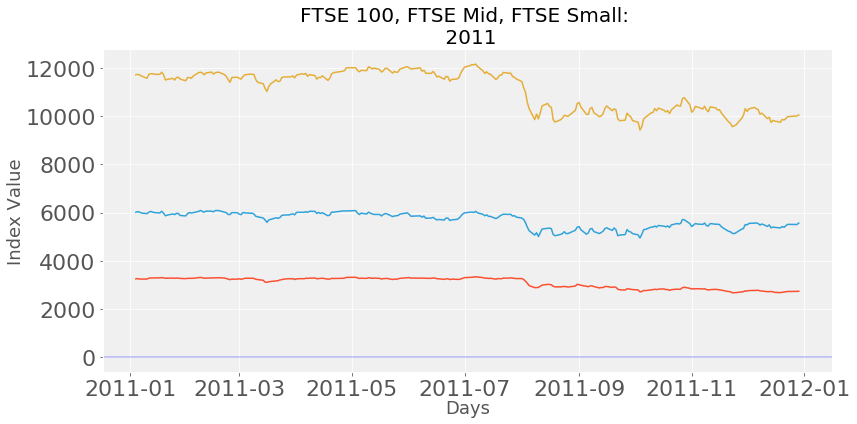

In [43]:
### Plot the raw data
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(df[['FTSE100', 'FTSE Mid', 'FTSE Small']])

axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('Index Value', fontsize=18)
axes.set_title('FTSE 100, FTSE Mid, FTSE Small: \n ' + str(df.index.year.min()), fontsize=20)
axes.axhline(y=0, linewidth=0.4)
fig.tight_layout()

Let's analyze log differences of each of the three **FTSE** indices.

In [44]:
dflog = np.log(df).diff().dropna()

print(dflog.head(), '\n')
print(dflog.tail(), '\n')
print(dflog.info(), '\n')

print(dflog['FTSE100'].describe(), '\n')
print(dflog['FTSE Mid'].describe(), '\n')
print(dflog['FTSE Small'].describe(), '\n')

            FTSE100  FTSE Mid  FTSE Small
date                                     
2011-01-05    0.005     0.002       0.003
2011-01-06   -0.004    -0.002      -0.005
2011-01-07   -0.006    -0.004       0.000
2011-01-10   -0.005    -0.009      -0.001
2011-01-11    0.010     0.014       0.012 

            FTSE100  FTSE Mid  FTSE Small
date                                     
2011-12-21   -0.006    -0.003       0.005
2011-12-22    0.012     0.006       0.004
2011-12-23    0.010     0.008       0.004
2011-12-28   -0.001     0.003       0.002
2011-12-29    0.011     0.004       0.003 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2011-01-05 to 2011-12-29
Data columns (total 3 columns):
FTSE100       249 non-null float64
FTSE Mid      249 non-null float64
FTSE Small    249 non-null float64
dtypes: float64(3)
memory usage: 7.8 KB
None 

count   249.000
mean     -0.000
std       0.013
min      -0.048
25%      -0.007
50%      -0.000
75%       0.008
max       0.039
Name:

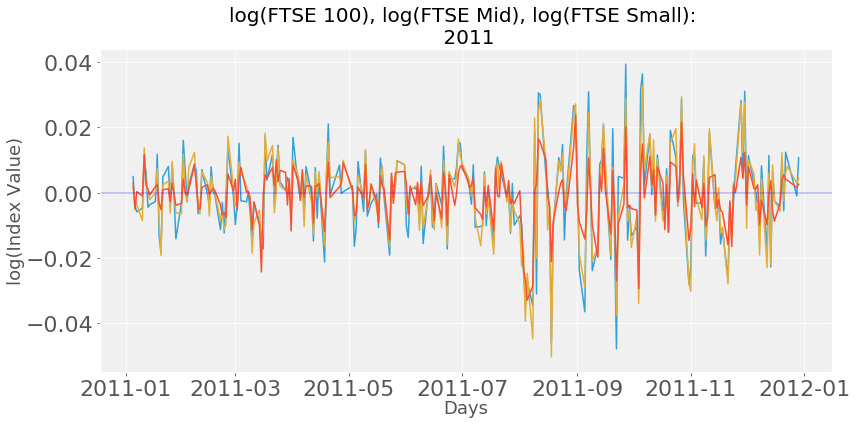

In [45]:
### Plot the log data
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dflog[['FTSE100', 'FTSE Mid', 'FTSE Small']])

axes.set_xlabel('Days', fontsize=18)
axes.set_ylabel('log(Index Value)', fontsize=18)
axes.set_title('log(FTSE 100), log(FTSE Mid), log(FTSE Small): \n ' + str(dflog.index.year.min()), fontsize=20)
axes.axhline(y=0, linewidth=0.4)
fig.tight_layout()

Let's start with a VAR($1$) model so we familiarize ourselves with the `statsmodels` routines.

In [46]:
### Start by setting up a VAR(1) model 
### NOTE: ValueWarning is due to gaps in dailydates, this can be ignored for now.
var_model = sm.tsa.VAR(dflog)
var_est = var_model.fit(maxlags=1)
var_est.summary()

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, May, 2019
Time:                     01:44:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -30.4129
Nobs:                     248.000    HQIC:                  -30.5145
Log likelihood:           2748.59    FPE:                5.22404e-14
AIC:                     -30.5829    Det(Omega_mle):     4.97920e-14
--------------------------------------------------------------------
Results for equation FTSE100
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000332         0.000850           -0.391           0.696
L1.FTSE100            0.462384         0.182258            2.537           0.011
L1.FTSE Mid          -0.527746         0.215400           

How else could we estimate our Var($1$)? We could estimate each equation in our system equation-by-equation via OLS. We will get the same thing as above.

In [47]:
### Fit each equation by OLS
Y = dflog.values[1:,:]
y_lags = dflog.shift(1).values[1:,:]
y_lags = sm.add_constant(y_lags)

for k in range(3):
    ols_fit = sm.OLS(Y[:,k], y_lags).fit()
    print(dflog.columns[k])
    print(ols_fit.summary(), '\n')


FTSE100
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.058
Date:                Sat, 18 May 2019   Prob (F-statistic):             0.0290
Time:                        01:44:06   Log-Likelihood:                 721.60
No. Observations:                 248   AIC:                            -1435.
Df Residuals:                     244   BIC:                            -1421.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.391 

Let's now compare various VAR($p$) models with increasing lag order $p$. For now, let's consider $p=0,1,...,5$.

In [48]:
### Compare different lag orders of the VAR(p): p = 0,1,...,5
for maxlag in range(0,6):
    print('Lag #%d' % maxlag)
    var_est = var_model.fit(maxlags=maxlag)
    print('AIC: %.03f' % var_est.aic)
    print('BIC: %.03f' % var_est.bic)
    if maxlag>0:
        print('VAR Stable? ',  var_est.is_stable()) # need to check VAR(p) is stable.
    print()

Lag #0
AIC: -30.362
BIC: -30.320

Lag #1
AIC: -30.583
BIC: -30.413
VAR Stable?  True

Lag #2
AIC: -30.584
BIC: -30.286
VAR Stable?  True

Lag #3
AIC: -30.621
BIC: -30.193
VAR Stable?  True

Lag #4
AIC: -30.601
BIC: -30.043
VAR Stable?  True

Lag #5
AIC: -30.551
BIC: -29.863
VAR Stable?  True



#### Question: 
Based on *AIC* and *BIC*, what is the optimal lag?

#### Answer:
Based on *AIC*, the optimal $p$ is 0. Based on *BIC*, the **optimal $p$ is 5**. Since *BIC* tends to penalize more parameters (hence more lags) more heavily, let's go with an optimal lag of $p=5$ for now.

Assuming $p=5$ is the optimal lag, let's run Granger-causality tests:

In [49]:
### Granger causality tests for chosen p_lag
# http://www.statsmodels.org/devel/vector_ar.html#granger-causality
p_lag = 5
var_est = var_model.fit(maxlags=p_lag)
print(var_est.test_causality('FTSE100', ['FTSE Mid', 'FTSE Small']).summary(), '\n')
print(var_est.test_causality('FTSE Mid', ['FTSE100', 'FTSE Small']).summary(), '\n')
print(var_est.test_causality('FTSE Small', ['FTSE Mid', 'FTSE100']).summary())

Granger causality F-test. H_0: %s do not Granger-cause FTSE100. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    2.841          1.845       0.002  (10, 684)
----------------------------------------------- 

Granger causality F-test. H_0: %s do not Granger-cause FTSE Mid. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    4.189          1.845       0.000  (10, 684)
----------------------------------------------- 

Granger causality F-test. H_0: %s do not Granger-cause FTSE Small. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    3.015          1.845       0.001  (10, 684)
-----------------------------------------------


What do we find? 

#### Solution: 
We reject all of our Granger causality null hypotheses at the 5% significance level. That is, we reject the null hypothesis that:

* **FTSE Mid** and **FTSE Small** do not Granger-cause **FTSE100**.
* **FTSE 100** and **FTSE Small** do not Granger-cause **FTSE Mid**.
* **FTSE 100** and **FTSE Mid** do not Granger-cause **FTSE Small**.

### Discussion:

Extend the maximum lag length to $p=10$. What do you find this time in terms of the optimal lag length and Granger-causality tests at this lag length? 

## Exercise 5: Estimating ARMA($p$,$q$) models by Maximum Likelihood Estimation (MLE)

We've seen that **OLS** is inconsistent for ARMA($p$,$q$) models when $p$ and $q$ are not zero. 

One approach is to estimate the AR terms using instrumental variables (**IV**). 
Another approach is to estimate both the AR and MA terms by maximum likelihood (**MLE**). 

**MLE** works by choosing parameters $\hat{\phi}$, $\hat{\theta}$ that maximize the log-likelihood function. Unlike **OLS**, in general, we won't have a closed form solution and hence must use numerical procedures to choose the parameters.

#### Part 1:
The dataset `arma.csv` has various ARMA($p$,$q$) processes. Determine the lag order of each series and estimate using **MLE**.

#### Part 2:
Use `arma_from_roots` to simulate a process with `ar_roots=[2,1.25]` and `ma_roots=[2, -1.5]`.

**Hints**:
* Estimate using `sm.tsa.ARMA()` and the method `fit()`
* After fitting, examine `aic`, `bic`. Plot *ACF*s and *PACF*s of the residuals (attribute `resid`)
* Note that `fit()` takes an optional argument that specifies the starting values. If you don't provide any, the function attempts to choose "good" values; however, these can frequently be unstable and lead to an error. On the other hand, starting at all zeros will always be stable but can either converge slowly or not at all. In practice you will find it useful to experiment with multiple starting values.
* Other fitting options include number of iterations, tolerances, etc.

In [50]:
### Load the data
df = pd.read_csv('arma.csv')
print(df.head(), '\n')
print(df.tail(), '\n')

      y1     y2     y3
0  1.624  0.490 -0.140
1  0.417  0.108  0.039
2  0.223 -0.799  0.373
3 -1.023 -0.527  1.005
4  0.229 -1.553  1.244 

         y1     y2     y3
1995 -1.528 -0.587  0.286
1996 -0.736 -0.208 -0.538
1997 -1.581 -0.684 -1.151
1998 -0.371  1.390 -1.524
1999  0.776  0.660 -0.701 



### Part 1:

AIC: 5787.287
BIC: 5809.691
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(1, 1)   Log Likelihood               -2889.644
Method:                       css-mle   S.D. of innovations              1.026
Date:                Sat, 18 May 2019   AIC                           5787.287
Time:                        01:44:06   BIC                           5809.691
Sample:                             0   HQIC                          5795.513
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1674      0.117      1.431      0.153      -0.062       0.397
ar.L1.y        0.8434      0.014     58.327      0.000       0.815       0.872
ma.L1.y       -0.1997   

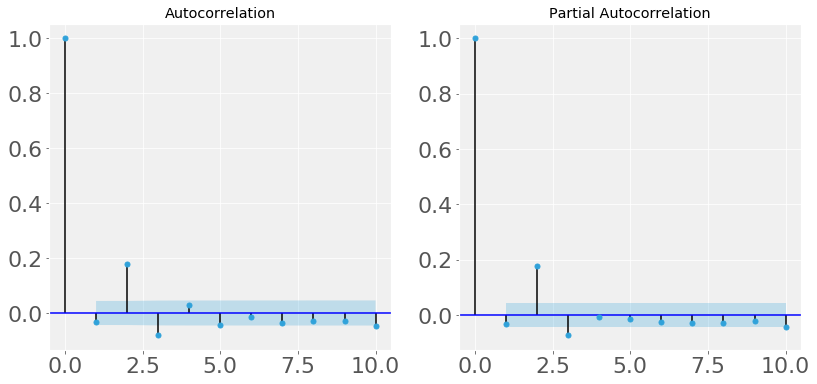

In [51]:
### Determine the order and estimate
ysim = df['y1'].values

order = (1,1)
arma_model = sm.tsa.ARMA(ysim, order=order)

### Default starting params, zeros, etc, start_params = None
start_params = np.zeros(np.sum(order)+1)
try:
    ests = arma_model.fit(start_params=start_params, maxiter=500, trend='c')
    print('AIC: %.03f' % ests.aic)
    print('BIC: %.03f' % ests.bic)
    
    ### ACF and PACF of residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
    sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
    print(ests.summary())
except Exception:
    print('Convergence error')

Let's write a function that gives us information criteria *AIC*, *BIC*, and *Hannan-Quinn* to aid us in determining the lag order of a process.

In [52]:
### Let's use information criteria
def calc_arma_ic(x, order_list):
    ic_array = np.empty((3, len(order_list)))
    for idx, order in enumerate(order_list):
        # Set up model with given order
        model = tsa.arima_model.ARMA(x , order=order )
        # Fit and save criteria
        try:
            start_params = None
            res = model.fit(start_params=start_params, maxiter=500 )
        except Exception:
            start_params = np.zeros(np.sum(order)+1)
            res = model.fit(start_params=start_params, maxiter=500 )
        ic_array[0,idx] = res.aic
        ic_array[1,idx] = res.hqic
        ic_array[2,idx] = res.bic
    
    ### Return min orders for each criteria
    aic_order = order_list[ np.argmin(ic_array[0,:]) ]
    hqic_order = order_list[ np.argmin(ic_array[1,:]) ]
    bic_order = order_list[ np.argmin(ic_array[2,:]) ]
    
    ### Tuple of best orders
    ic_orders = (aic_order, hqic_order, bic_order)
    return ic_orders, ic_array

Let's work with process `y3`:

In [53]:
ysim = df['y3'].values
order_list = [(p,q) for p in range(4) for q in range(4)]
ic_orders, ic_array = calc_arma_ic(ysim, order_list)
print("(AIC, BIC, Hannan-Quinn): (p,q) =", ic_orders)

(AIC, BIC, Hannan-Quinn): (p,q) = ((3, 3), (1, 2), (1, 2))


Let's go with *BIC* and choose $p=1$ and $q=2$:

In [54]:
order = (1,2)
arma_model = sm.tsa.ARMA(ysim, order=order)
try:
    start_params = None
    ests = arma_model.fit(start_params=start_params, maxiter=500)
except Exception:
    start_params = np.zeros(np.sum(order)+1)
    ests = arma_model.fit(start_params=start_params, maxiter=500)

print(ests.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(1, 2)   Log Likelihood               -2849.049
Method:                       css-mle   S.D. of innovations              1.005
Date:                Sat, 18 May 2019   AIC                           5708.097
Time:                        01:44:10   BIC                           5736.102
Sample:                             0   HQIC                          5718.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0376      0.083      0.454      0.650      -0.125       0.200
ar.L1.y        0.8584      0.025     34.314      0.000       0.809       0.907
ma.L1.y       -0.1377      0.035     -3.882      0.0

### Solution: 
It turns out the process `y3` is an ARMA($1$, $2$) with $\phi_1=0.8$,  $\theta_1=-0.071$, and $\theta_2=-0.286$.

Process `y1` is an AR($3$) with $\phi_1=0.633$, $\phi_2=0.3$, and $\phi_3=-0.133$

Process `y2` is an MA($3$) with $\theta_1=-0.267$, $\theta_2=-0.587$, and $\theta_3=0.213$

### Part 2:

Let's use the functions `_roots2coef` and `arma_from_roots` from **Lab 3**:

In [55]:
def _roots2coef(roots):
    """Given roots, get the coefficients"""
    ### SymPy: package for symbolic computation
    from sympy import symbols, expand, factor, collect, simplify, Mul
    
    N_roots = len(roots)
    L = symbols("L", commutative=False) # symbolic variable
    ## Construct lag polynomial in the canonical form
    expr = expand(1)
    for r in roots:
        expr*= -(L - r)
    expr_expand = expand(expr)
    expr_expand = expand((expr_expand.as_coefficients_dict()[1]**-1)*expr_expand).evalf(3)
    
    ## factor out the lag polynomials and get "factor list" in the canonical form
    expr_factor = factor(expr_expand)     
    for f in range(1, len(expr_factor.args)):
        if f==1:
            expr = expand(expr_factor.args[f]*-1).evalf(3)
        else:
            expr = Mul(expr, expand(expr_factor.args[f]*-1).evalf(3))
            
    coef_list = [expr_expand.coeff(L,n) for n in range(N_roots + 1)]
    ### convert to numpy floats
    coefs = np.array(coef_list).astype(float)
    ### normalize zero lag to 1
    coefs /= coefs[0]
    return coefs, expr, expr_expand

def arma_from_roots(ar_roots=[], ma_roots=[]):
    """Create an ARMA model class from roots"""    
    ar_coef, ar_expr, ar_expr_expand = _roots2coef(ar_roots)
    if len(ma_roots)>0:
        ma_coef, ma_expr, ma_expr_expand = _roots2coef(ma_roots)  
    print("AR lag polynomials in the form:", ar_expr_expand)
    if len(ma_roots)>0:
        print("MA lag polynomials in the form:", ma_expr_expand, "\n")
    print("factored AR lag polynomials in the form:", ar_expr)
    if len(ma_roots)>0:
        print("factored MA lag polynomials in the form:", ma_expr, "\n") 
    if len(ma_roots)>0:
        arma_process = sm.tsa.ArmaProcess(ar_coef, ma_coef)
    else:
        arma_process = sm.tsa.ArmaProcess(ar_coef, [1])
    ### Note: arma_process' has many helpful methods: arcoefs, macoefs, generate_sample, ...
    return arma_process

In [56]:
### Part 2: Get coefficients
arma_process = arma_from_roots(ar_roots=[2, 1.25], ma_roots=[2, -1.5])
print('AR coefficients :', arma_process.arcoefs)
print('MA coefficients :', arma_process.macoefs)

np.random.seed(1)
nsample = 2000
ysim = arma_process.generate_sample(nsample)

AR lag polynomials in the form: 1.0 - 1.3*L + 0.4*L**2
MA lag polynomials in the form: 1.0 + 0.167*L - 0.333*L**2 

factored AR lag polynomials in the form: (1.0 - 0.5*L)*(1.0 - 0.8*L)
factored MA lag polynomials in the form: (-1.0 - 0.667*L)*(1.0 - 0.5*L) 

AR coefficients : [ 1.3 -0.4]
MA coefficients : [ 0.167 -0.333]


Let's do what we did for **Part 1**:

In [57]:
### as in part 1, determine the order (p,q) and estimate by MLE
order_list = [(p,q) for p in range(4) for q in range(4)]
ic_orders, ic_array = calc_arma_ic(ysim, order_list)
print("(AIC, BIC, Hannan-Quinn): (p,q) =", ic_orders)

(AIC, BIC, Hannan-Quinn): (p,q) = ((1, 1), (1, 1), (1, 1))


Here, all three information criteria tell us $p=1$ and $q=1$. Why is this the case?

We can see we have a **common factor** (Recall **Lab 2**). One of the AR and MA roots cancel each other out. Our ARMA($2$,$2$) model is observationally equivalent to an ARMA($1$,$1$)!

We proceed as before:

In [58]:
order = (1,1)
arma_model = sm.tsa.ARMA(ysim, order=order)
try:
    start_params = None
    ests = arma_model.fit(start_params=start_params, maxiter=500)
except Exception:
    start_params = np.zeros(np.sum(order)+1)
    ests = arma_model.fit(start_params=start_params, maxiter=500)

print(ests.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(1, 1)   Log Likelihood               -2848.229
Method:                       css-mle   S.D. of innovations              1.005
Date:                Sat, 18 May 2019   AIC                           5704.458
Time:                        01:44:20   BIC                           5726.862
Sample:                             0   HQIC                          5712.684
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2779      0.178      1.562      0.118      -0.071       0.627
ar.L1.y        0.7910      0.014     55.236      0.000       0.763       0.819
ma.L1.y        0.6585      0.018     37.475      0.0

In [59]:
arma_process_simplify = arma_from_roots(ar_roots=[1.25], ma_roots=[-1.5])
print('AR coefficient :', arma_process_simplify.arcoefs)
print('MA coefficient :', arma_process_simplify.macoefs)

AR lag polynomials in the form: 1.0 - 0.8*L
MA lag polynomials in the form: 1.0 + 0.667*L 

factored AR lag polynomials in the form: 1.0 - 0.8*L
factored MA lag polynomials in the form: -1.0 - 0.667*L 

AR coefficient : [0.8]
MA coefficient : [0.667]


The AR coefficient $\phi$ is 0.8 and the MA coefficient $\theta$ is 0.667!

That is all for today! 😎